
# Training a TFNO on Darcy-Flow

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator


In [12]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, FNO, UNO 
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small, load
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda'

Loading the Darcy flow dataset in 128x128 resolution



In [40]:
# train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        # n_train=1000, batch_size=32, 
        # test_resolutions=[16, 32], n_tests=[100, 50],
        # test_batch_sizes=[32, 32],
# )

train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)


UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


We create a tensorized FNO model



In [79]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
# model = FNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)

# model = UNO(3,1, hidden_channels=64, projection_channels=64,uno_out_channels = [32,64,64,64,32], \
            # uno_n_modes= [[16,16],[8,8],[8,8],[8,8],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],\
            # horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 393665 parameters.


Create the optimizer



In [81]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [82]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [83]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x7f68d9fda2e0>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at

Create the trainer



In [84]:
trainer = Trainer(model, n_epochs=30,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=1,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


Actually train the model on our small Darcy-Flow dataset



In [85]:
trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Training on raw inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
.. patched inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
Raw outputs of size out.shape=torch.Size([32, 1, 16, 16])
.. Processed (unpatched) outputs of size out.shape=torch.Size([32, 1, 16, 16])
[0] time=0.43, avg_loss=18.2475, train_err=0.5474, 16_h1=0.3895, 16_l2=0.3012, 32_h1=0.4765, 32_l2=0.3110
[1] time=0.40, avg_loss=10.9803, train_err=0.3294, 16_h1=0.2849, 16_l2=0.2234, 32_h1=0.3869, 32_l2=0.2522
[2] time=0.34, avg_loss=9.0237, train_err=0.2707, 16_h1=0.2468, 16_l2=0.1923, 32_h1=0.3384, 32_l2=0.2081
[3] time=0.36, avg_loss=7.6845, train_err=0.2305, 16_h1=0.2152, 16_l2=0.1659, 32_h1=0.3292, 32_l2=0.1959
[4] time=0.38, avg_loss=6.9463, train_err=0.2084, 16_h1=0.2748, 16_l2=0.2284, 32_h1=0.3785, 32_l2=0.2574
[5] time=0.33, avg_loss=7.4096, train_err=0.222

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



/tmp/ipykernel_960407/4009600171.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


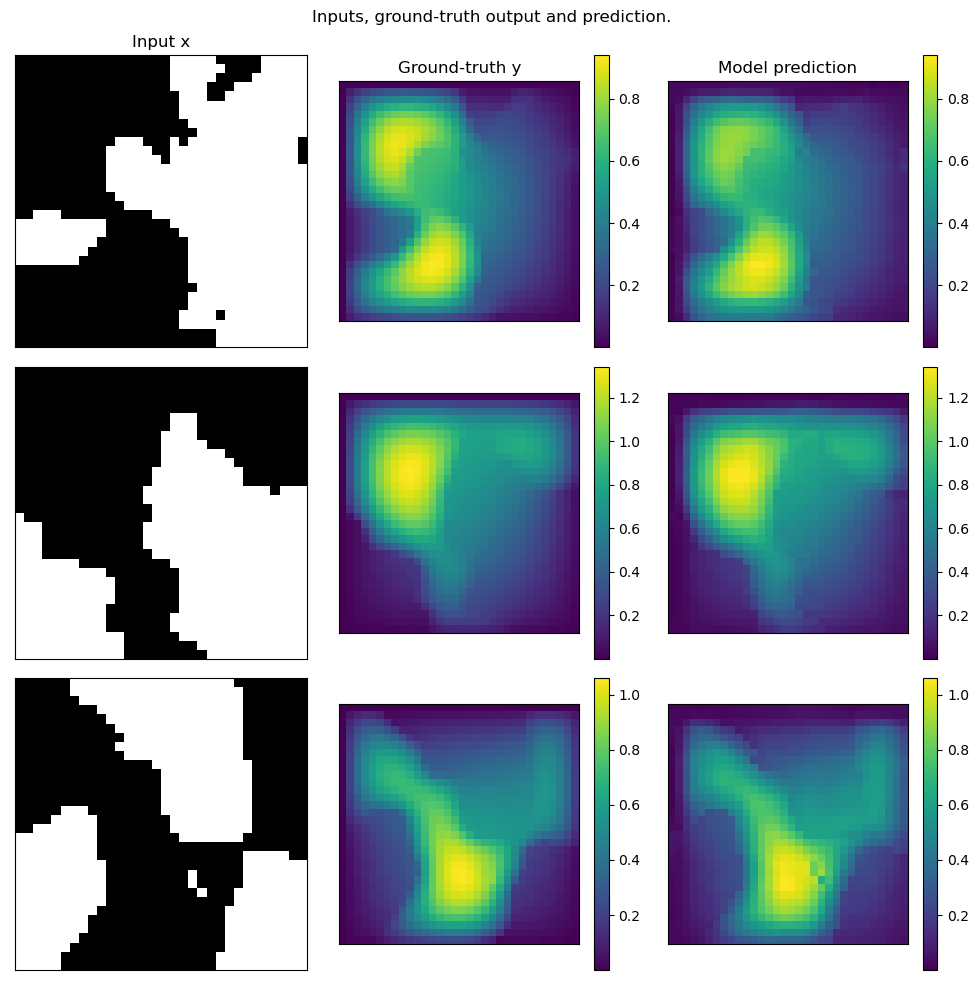

In [86]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(10,10))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x'].to(device)
    # Ground-truth
    y = data['y'].to(device)


    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3,3,  index*3 + 1)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    y_cpu = y.cpu().squeeze()
    im = ax.imshow(y_cpu)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.colorbar(im, ax=ax)
    im.set_clim(y_cpu.min(), y_cpu.max())

    ax = fig.add_subplot(3,3, index*3 + 3)
    ax.imshow(out.squeeze().cpu().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.colorbar(im, ax=ax)


    # ax = fig.add_subplot(4, 4, index*4 + 4)
    # ax.imshow(torch.abs(y.squeeze() - out.squeeze().detach().numpy()))
    # if index == 0: 
        # ax.set_title('Absolute Value difference')
    # plt.xticks([], [])
    # plt.yticks([], [])
    # plt.colorbar()


fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show() 

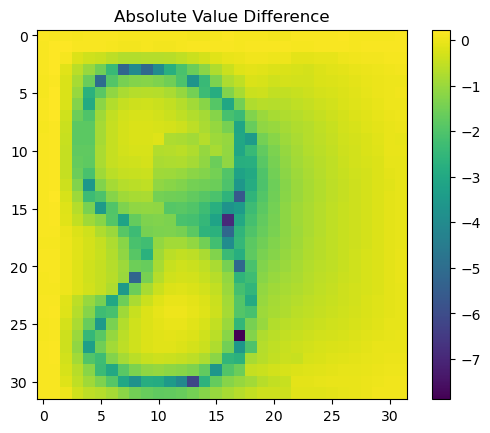

In [57]:
import numpy as np
index=0

data = test_samples[index]
# Input x
x = data['x'].to(device)
# Ground-truth
y = data['y'].to(device)
# Model prediction
out = model(x.unsqueeze(0))

# x.shape, out.shape

plt.imshow(np.log(torch.abs(y.squeeze().cpu() - out.squeeze().cpu().detach().numpy())))
plt.title('Absolute Value Difference')
plt.colorbar() 